# Rosbank ML Competition, may 2018 

https://boosters.pro/champ_15

__Task 1:__ binary classification for field 'target_flag' with metric ROC-AUC (final score 0.8570, the first place - 0.8747)

__Task 2:__ regression for field 'target_sum' with metric RMSLE (final score 4.6074, the first place - 3.8440)

# 0 step - prepairing the environment

### Importing all libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import calendar
import time
import datetime
from dateutil.relativedelta import relativedelta

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import requests

In [5]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.preprocessing import scale

In [7]:
from scipy.stats import ttest_rel

In [1]:
from xgboost import XGBClassifier, XGBRegressor, DMatrix, plot_importance
from xgboost import cv as XGBcv

### Loading data

In [8]:
df = pd.read_csv('train.csv') # main features
df_ohe = df[['cl_id']] # for OneHotEncoded features
df_amount = df[['cl_id']] # for amount features

df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [9]:
df_test = pd.read_csv('test.csv')
df_ohe_test = df_test[['cl_id']]
df_amount_test = df_test[['cl_id']]

df_test.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,NaN,810,08APR17:00:00:00,130.00,POS


### Seed averaging cross-validation function

In [ ]:
def CV_score_mean(task_num, X, y, params_est = {}, range_rs = range(10)):
    
    scores_train_mean = np.array([])
    scores_train_std = np.array([])
    scores_test_mean = np.array([])
    scores_test_std = np.array([])
    
    dtrain = DMatrix(data = X, label = y, feature_names = X.columns)
    metrics = 'auc' if task_num == 1 else 'rmse'
        
    for i in range_rs:
        cv = XGBcv(params = params_est,
                   dtrain = dtrain,
                   metrics = metrics,
                   num_boost_round = 200,
                   seed = i)
        
        scores_train_mean = np.append(scores_train_mean, cv[cv.columns[2]])
        scores_train_std = np.append(scores_train_std, cv[cv.columns[3]])
        scores_test_mean = np.append(scores_test_mean, cv[cv.columns[0]])
        scores_test_std = np.append(scores_test_std, cv[cv.columns[1]])
    
    return scores_train_mean, scores_train_std, scores_test_mean, scores_test_std

### Tables & function for comparing scores

In [166]:
score_columns = [
        'Train Score Mean', 
        'Train Score Std', 
        'Test Score Mean', 
        'Test Score Std', 
        'Comments'
]
score_task1 = pd.DataFrame(columns = score_columns)
score_task2 = pd.DataFrame(columns = score_columns)

In [167]:
def add_score(cv, score_table, comments):
    row = score_table.shape[0]
    score_table.loc[row, 'Train Score Mean'] = res[0].mean()
    score_table.loc[row, 'Train Score Std'] = res[1].mean()
    score_table.loc[row, 'Test Score Mean'] = res[2].mean()
    score_table.loc[row, 'Test Score Std'] = res[3].mean()
    score_table.loc[row, 'Comments'] = comments

# 1 step - transforming source data for agregating

### Fields: PERIOD & TRDATETIME

__New features:__

- trx_date - date of transaction
- days_cnt - days from the first transaction of this clients to the last one
- days_cnt_POS - days from the first POS-transaction of this clients to the last one
- days_from_my_start - days from the first transaction of this clients to the current one
- days_from_all_start - days from the first transaction in dataset to the current one

In [10]:
def dates(df_in):
    period_split = df_in['PERIOD'].apply(lambda s: map(int, s.split('/')))
    df_in['year'] = period_split.apply(lambda a: a[2])
    df_in['month'] = period_split.apply(lambda a: a[1])
    df_in['day'] = df_in['TRDATETIME'].apply(lambda a: int(a[:2]))

    df_in['trx_date'] = df_in[['year', 'month', 'day']] \
                                .apply(lambda d: datetime.date(year = d[0], month = d[1], day = d[2]), axis = 1)
    df_in['is_weekend'] = df_in[['year', 'month', 'day']] \
                                .apply(lambda d: int(calendar.weekday(d[0], d[1], d[2]) > 4), axis = 1)
        
        
    df_in['first_date'] = df_in.groupby('cl_id')['trx_date'].transform('min')
    df_in['last_date'] = df_in.groupby('cl_id')['trx_date'].transform('max')

    df_in['days_cnt'] = df_in[['first_date', 'last_date']] \
                                .apply(lambda d: (d[1] - d[0]).days + 1, axis = 1)
    
    df_in['days_from_my_start'] = df_in[['first_date', 'trx_date']] \
                                .apply(lambda d: (d[1] - d[0]).days, axis = 1)
    df_in['days_from_all_start'] = (df_in['trx_date'] - min(df_in['trx_date'])).apply(lambda d: d.days)

    df_in['start_date'] = df_in[df_in['trx_category'] == 'POS'].groupby('cl_id')['trx_date'].transform('min')
    df_in['start_date'].fillna(df_in['first_date'], inplace = True) 
    df_in['start_date'] = df_in.groupby('cl_id')['start_date'].transform('max')
    
    df_in['end_date'] = df_in[df_in['trx_category'] == 'POS'].groupby('cl_id')['trx_date'].transform('max')
    df_in['end_date'].fillna(df_in['last_date'], inplace = True) 
    df_in['end_date'] = df_in.groupby('cl_id')['end_date'].transform('min')
    
    df_in['days_cnt_POS'] = df_in[['start_date', 'end_date']] \
                                .apply(lambda d: (d[1] - d[0]).days + 1, axis = 1)    
        
    df_in.drop(labels = ['PERIOD', 'TRDATETIME', 'year', 'day', 'first_date', 'last_date', 'start_date', 'end_date'], \
                                axis = 1, inplace = True)

In [11]:
dates(df)
dates(df_test)
df.head()

,cl_id,MCC,channel_type,currency,amount,trx_category,target_flag,target_sum,month,trx_date,is_weekend,days_cnt,days_from_my_start,days_from_all_start,days_cnt_POS
0,0,5200,NaN,810,5023.0,POS,0,0.0,10,2017-10-21,1,55,9,379,46
1,0,6011,NaN,810,20000.0,DEPOSIT,0,0.0,10,2017-10-12,0,55,0,370,46
2,0,5921,NaN,810,767.0,POS,0,0.0,12,2017-12-05,0,55,54,424,46
3,0,5411,NaN,810,2031.0,POS,0,0.0,10,2017-10-21,1,55,9,379,46
4,0,6012,NaN,810,36562.0,C2C_OUT,0,0.0,10,2017-10-24,0,55,12,382,46


### Field: channel_type

New OHE-features

In [12]:
def ch_types(df_in, df_bin):
    channel_type = {'type0': 0, 'type1': 1, 'type2': 2, 'type3': 3, 'type4': 4, 'type5': 5}

    df_in['channel_type'].fillna('type0', inplace = True)
    df_in['channel_type'].replace(channel_type, inplace = True)
    
    encoded = pd.DataFrame(ohe.fit_transform(df_in['channel_type'].values.reshape(-1, 1)), index = df_in.index)
    encoded.columns = encoded.columns.map(lambda x: 'ch_' + str(x))
    encoded = encoded.applymap(int)
    
    i = len(df_bin.columns)
    for c in encoded.columns:
        df_bin.insert(i, c, encoded[c])
        i += 1

In [13]:
ch_types(df, df_ohe)
ch_types(df_test, df_ohe_test)
df_ohe.head()

,cl_id,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


### Field: trx_category

New OHE-features. Changed 'amount'

In [14]:
def trx_categories(df_in, df_bin):
    categories =   {'POS': 0, \
                    'DEPOSIT': 1, \
                    'WD_ATM_ROS': 2, \
                    'WD_ATM_PARTNER': 3, \
                    'C2C_IN': 4, \
                    'WD_ATM_OTHER': 5, \
                    'C2C_OUT': 6, \
                    'BACK_TRX': 7, \
                    'CAT': 8, \
                    'CASH_ADV': 9}
    trx_sign = {0 : -1, 
                1 : 1,
                2 : -1,
                3 : -1,
                4 : 1,
                5 : -1,
                6 : -1,
                7 : 1,
                8 : -1,
                9 : -1}

    df_in['trx_category'].replace(categories, inplace = True)
    df_in['amount'] = df_in[['trx_category', 'amount']].apply(lambda d: d[1] * trx_sign[d[0]], axis = 1)
    
    encoded = pd.DataFrame(ohe.fit_transform(df_in['trx_category'].values.reshape(-1, 1)), index = df_in.index)
    encoded.columns = encoded.columns.map(lambda x: 'trx_' + str(x))
    encoded = encoded.applymap(int)
    
    i = len(df_bin.columns)
    for c in encoded.columns:
        df_bin.insert(i, c, encoded[c])
        i += 1

In [15]:
trx_categories(df, df_ohe)
trx_categories(df_test, df_ohe_test)
df_ohe.head()

,cl_id,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,trx_0,trx_1,trx_2,trx_3,trx_4,trx_5,trx_6,trx_7,trx_8,trx_9
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Field: MCC

New OHE-features for each MCC-value and for categories of MCC

__New features:__

- is_cash - has the client got a cashback from this transaction?
- is_bonus - is the transaction's date in a bonus period?

In [16]:
def mcc_cat(m):
    beauty = [5698, 5912, 7230, 7297, 7298, 7997, 8011, 8021, 8031, 8041, 8042, 8043, 8044, 8049, 8050, 8062, 8071, 8099]
    home = [5039, 5200, 5211, 5231, 5251, 5712, 5713, 5714, 5718, 5719, 5722, 5932, 5950]
    children = [5611, 5641, 5651, 5661, 5943, 5945, 5970, 7832, 7911, 7922, 7929, 7933, 7941, 7991, 7996, 7998, 7999]
    cafe = [5462, 5499, 5812, 5813, 5814]
    no_cash = [4812, 4814, 4829, 4900, 5933, 5960, 6010, 6011, 6012, 6050, 6051, 6211, 6300, 6529, 6530, 6532, 6533, 6534, 6536, 6537, 6538, 6540, 7276, 7800, 7801, 7802, 7994, 7995, 9222, 9311]
    
    if m in beauty:
        return 1
    if m in home:
        return 2
    if m in children:
        return 3
    if m in cafe:
        return 4
    if m in no_cash:
        return 5
    return 0

In [17]:
def is_bonus(d):
    mcc_cat = d[0]
    trx_cat = d[1]
    month = d[2]
    if trx_cat != 0:
        return 0
    return  ((mcc_cat == 1) & (month in [1, 2, 3])) or \
            ((mcc_cat == 2) & (month in [4, 5, 6])) or \
            ((mcc_cat == 3) & (month in [7, 8, 9])) or \
            ((mcc_cat == 4) & (month in [10, 11, 12]))

In [18]:
def mccs(df_in, df_bin):
    df_in['MCC_cat'] = df_in['MCC'].apply(mcc_cat)
    
    df_in['is_cash'] = ((df_in['MCC_cat'] != 5) & (df_in['trx_category'] == 0)).astype(int)
    df_in['is_bonus'] = df_in[['MCC_cat', 'trx_category', 'month']].apply(is_bonus, axis = 1).map(int)
    df_in.drop(['month'], axis = 1, inplace = True)
    
    encoded = pd.DataFrame(ohe.fit_transform(df_in['MCC'].values.reshape(-1, 1)), index = df_in.index)
    encoded.columns = encoded.columns.map(lambda x: 'mcc_' + str(x))
    encoded = encoded.applymap(int)
    
    i = len(df_bin.columns)
    for c in encoded.columns:
        df_bin.insert(i, c, encoded[c])
        i += 1
        
    encoded = pd.DataFrame(ohe.fit_transform(df_in['MCC_cat'].values.reshape(-1, 1)), index = df_in.index)
    encoded.columns = encoded.columns.map(lambda x: 'mcc_cat_' + str(x))
    encoded = encoded.applymap(int)
    
    i = len(df_bin.columns)
    for c in encoded.columns:
        df_bin.insert(i, c, encoded[c])
        i += 1

In [19]:
mccs(df, df_ohe)
mccs(df_test, df_ohe_test)
df.head()

,cl_id,MCC,channel_type,currency,amount,trx_category,target_flag,target_sum,trx_date,is_weekend,days_cnt,days_from_my_start,days_from_all_start,days_cnt_POS,MCC_cat,is_cash,is_bonus
0,0,5200,0,810,-5023.0,0,0,0.0,2017-10-21,1,55,9,379,46,2,1,0
1,0,6011,0,810,20000.0,1,0,0.0,2017-10-12,0,55,0,370,46,5,0,0
2,0,5921,0,810,-767.0,0,0,0.0,2017-12-05,0,55,54,424,46,0,1,0
3,0,5411,0,810,-2031.0,0,0,0.0,2017-10-21,1,55,9,379,46,0,1,0
4,0,6012,0,810,-36562.0,6,0,0.0,2017-10-24,0,55,12,382,46,5,0,0


### Field: currency

New OHE-features

In [20]:
def currencies(df_in, df_bin):
    encoded = pd.DataFrame(ohe.fit_transform(df_in['currency'].values.reshape(-1, 1)), index = df_in.index)
    encoded.columns = encoded.columns.map(lambda x: 'cur_' + str(x))
    encoded = encoded.applymap(int)
    
    i = len(df_bin.columns)
    for c in encoded.columns:
        df_bin.insert(i, c, encoded[c])
        i += 1    

In [21]:
currencies(df, df_ohe)
currencies(df_test, df_ohe_test)
df_ohe.head()

,cl_id,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,trx_0,trx_1,trx_2,...,cur_49,cur_50,cur_51,cur_52,cur_53,cur_54,cur_55,cur_56,cur_57,cur_58
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Field: amount

New features in amount-dataset - for each currency, all in RUB 

__New features:__

- cashback - cashback 7% for this transaction (0 if none)
- [mcc_cat_0_sum, ..., mcc_cat_5_sum] - amount for each MCC-category

In [ ]:
# Loading external data for exchange rates

import requests

cbr = pd.DataFrame(columns = df['currency'].unique(), index = sorted(df['trx_date'].unique()))

for d in cbr.index:
    req = 'http://www.cbr.ru/currency_base/daily.aspx?date_req=' + d.strftime("%d.%m.%Y")
    cur_table = pd.read_html(requests.get(req, headers = {'User-agent': 'Mozilla/5.0'}).text, 
                             converters = {u'Цифр. код': str})[0]
    cur_table.drop(0, inplace = True)
    cur_table[0] = cur_table[0].map(int)
    cur_table[2] = cur_table[2].map(int)
    cur_table[4] = cur_table[4].map(float)
    for c in cur_table.index:
        if cur_table.loc[c, 0] in cbr.columns:
            cbr.loc[d, cur_table.loc[c, 0]] = (cur_table.loc[c, 4] / cur_table.loc[c, 2]) / 10000
            
    cbr.to_csv('cbr.csv')

In [22]:
cbr = pd.read_csv('cbr.csv', index_col = [0])

cbr.drop('344', axis = 1, inplace = True)

rare_currencies = []
for c in cbr.columns:
    if np.isnan(cbr[c].max()):
        rare_currencies.append(c)
cbr.drop(rare_currencies, axis = 1, inplace = True)

cbr.head()

,810,978,985,840,949,51,826,203,702,756,...,392,348,356,986,498,578,208,410,946,710
2016-10-07,1,69.8518,16.2605,62.3900,20.4336,0.131624,79.3850,2.58536,45.4937,63.9307,...,0.602249,0.229299,0.936295,19.3728,3.15279,7.76546,9.38901,0.056073,15.6123,4.53337
2016-10-08,1,69.2312,16.1679,62.3031,20.4139,0.131552,77.5611,2.56354,45.3245,63.4516,...,0.600078,0.227458,0.934009,19.2978,3.14880,7.70992,9.30939,0.055890,15.4288,4.47679
2016-10-09,1,69.2312,16.1679,62.3031,20.4139,0.131552,77.5611,2.56354,45.3245,63.4516,...,0.600078,0.227458,0.934009,19.2978,3.14880,7.70992,9.30939,0.055890,15.4288,4.47679
2016-10-10,1,69.2312,16.1679,62.3031,20.4139,0.131552,77.5611,2.56354,45.3245,63.4516,...,0.600078,0.227458,0.934009,19.2978,3.14880,7.70992,9.30939,0.055890,15.4288,4.47679
2016-10-11,1,69.7253,16.2894,62.3884,20.3977,0.131482,77.4053,2.58177,45.3866,63.7397,...,0.604568,0.229356,0.936692,19.3663,3.15292,7.67678,9.37523,0.056195,15.4419,4.52828


In [23]:
def amount_cur(df_in, df_am):
    for cur in [str(x) for x in df_in['currency'].unique()]:
        if cur in cbr.columns:
            df_am[cur] = df_in['amount'] * \
                        (df_in['currency'] == int(cur)).map(int) * \
                         df_in['trx_date'] \
                                .apply(lambda d: cbr.loc[datetime.datetime.strftime(d, '%Y-%m-%d'), cur])

    df_in['cashback'] = abs(.07 * df_in['is_cash'] * df_am.drop('cl_id', axis = 1).apply(sum, axis = 1))
    
    for mcc in df_in['MCC_cat'].unique():
        df_in['mcc_cat_' + str(mcc) + '_sum'] = df_am.drop('cl_id', axis = 1).sum(axis = 1) * (df_in['MCC_cat'] == mcc)

In [24]:
amount_cur(df, df_amount)
amount_cur(df_test, df_amount_test)
df_amount.head()

,cl_id,810,978,985,840,949,51,826,203,702,...,392,348,356,986,498,578,208,410,946,710
0,0,-5023.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,-767.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,0,-2031.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,0,-36562.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


### Saving new datasets

In [32]:
print df.shape, df_ohe.shape, df_amount.shape
print df_test.shape, df_ohe_test.shape, df_amount_test.shape

(490513, 24) (490513, 426) (490513, 31)
(518376, 22) (518376, 427) (518376, 31)


In [33]:
list(set(df_ohe.columns) ^ set(df_ohe_test.columns))

['cur_59']

In [34]:
df_ohe_test.drop('cur_59', axis = 1, inplace = True)

In [35]:
df.to_csv('df.csv', index = False)
df_ohe.to_csv('df_ohe.csv', index = False)
df_amount.to_csv('df_amount.csv', index = False)

In [36]:
df_test.to_csv('df_test.csv', index = False)
df_ohe_test.to_csv('df_ohe_test.csv', index = False)
df_amount_test.to_csv('df_amount_test.csv', index = False)

### Reloading new datasets (if it needs to skip the previous steps)

In [8]:
df = pd.read_csv('df.csv')
df_ohe = pd.read_csv('df_ohe.csv')
df_amount = pd.read_csv('df_amount.csv')

In [9]:
print df.shape, df_ohe.shape, df_amount.shape

(490513, 24) (490513, 426) (490513, 31)


In [58]:
df_test = pd.read_csv('df_test.csv')
df_ohe_test = pd.read_csv('df_ohe_test.csv')
df_amount_test = pd.read_csv('df_amount_test.csv')

In [59]:
print df_test.shape, df_ohe_test.shape, df_amount_test.shape

(518376, 22) (518376, 426) (518376, 31)


# 2 step - agregating data

__Aggregating functions, return the dataset "row-by-client"__

In [63]:
def aggregated_dataset(df_all, df_bin, df_amount):
    df_res =  \
        pd.DataFrame(df_all[['cl_id']] \
                        .sort_values(by = 'cl_id') \
                        .groupby(by = 'cl_id')['cl_id'] \
                        .first())
        
    df_res['am_cnt'] = \
        df_all[['cl_id', 'amount']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id') \
            .aggregate(np.count_nonzero) \
            .applymap(int)
        
    df_res['days_cnt_POS'] = \
        df_all[['cl_id', 'days_cnt_POS']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id') \
            .first()
        
    df_res['days_cnt'] = \
        df_all[['cl_id', 'days_cnt']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id') \
            .first()
        
    df_res['weekends%'] = \
        df_all[['cl_id', 'is_weekend']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id')['is_weekend'] \
            .mean()
        
    df_res['cash%'] = \
        df_all[['cl_id', 'is_cash']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id')['is_cash'] \
            .mean()
        
    df_res['bonus%'] = \
        df_all[['cl_id', 'is_bonus']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id')['is_bonus'] \
            .mean()

    df_res['days_from_my_start'] = \
        df_all[['cl_id', 'days_from_my_start']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id')['days_from_my_start'] \
            .median()

    df_res['days_from_all_start'] = \
        df_all[['cl_id', 'days_from_all_start']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id')['days_from_all_start'] \
            .median()
            
    df_res['cashback_cnt'] = \
        df_all[['cl_id', 'cashback']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id')['cashback'] \
            .aggregate(np.count_nonzero)

    df_res['cashback_median'] = \
        df_all[['cl_id', 'cashback']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id')['cashback'] \
            .median()
        
    df_res['cashback_sum'] = \
        df_all[['cl_id', 'cashback']] \
            .sort_values(by = 'cl_id') \
            .groupby(by = 'cl_id')['cashback'] \
            .sum()
            
    for i in range(6):
        mcc = 'mcc_cat_' + str(i)
        df_res[mcc + '_cnt'] = \
            df_all[['cl_id', mcc + '_sum']] \
                .sort_values(by = 'cl_id') \
                .groupby(by = 'cl_id')[mcc + '_sum'] \
                .aggregate(np.count_nonzero)

        df_res[mcc + '_median'] = \
            df_all[['cl_id', mcc + '_sum']] \
                .sort_values(by = 'cl_id') \
                .groupby(by = 'cl_id')[mcc + '_sum'] \
                .median()

        df_res[mcc + '_sum'] = \
            df_all[['cl_id', mcc + '_sum']] \
                .sort_values(by = 'cl_id') \
                .groupby(by = 'cl_id')[mcc + '_sum'] \
                .sum()
            
    cols = df_bin.drop('cl_id', axis = 1).columns
    for c in cols:
        df_res[c] = \
            df_bin[['cl_id', c]] \
                .sort_values(by = 'cl_id') \
                .groupby(by = 'cl_id')[c] \
                .mean()
                
    cols = df_amount.drop('cl_id', axis = 1).columns
    for c in cols:
        df_res[c + '_cnt'] = \
            df_amount[['cl_id', c]] \
                .sort_values(by = 'cl_id') \
                .groupby(by = 'cl_id')[c] \
                .aggregate(np.count_nonzero)

        df_res[c + '_median'] = \
            df_amount[['cl_id', c]] \
                .sort_values(by = 'cl_id') \
                .groupby(by = 'cl_id')[c] \
                .median()

        df_res[c + '_sum'] = \
            df_amount[['cl_id', c]] \
                .sort_values(by = 'cl_id') \
                .groupby(by = 'cl_id')[c] \
                .sum()
                
    return df_res

In [98]:
def target_field(df_all, task):
    if task == 1:
        res = pd.DataFrame(df_all[['cl_id', 'target_flag']] \
                                .sort_values(by = 'cl_id') \
                                .groupby(by = 'cl_id') \
                                .first()['target_flag'])
    else:
        res = pd.DataFrame(df_all[['cl_id', 'target_sum']] \
                                .sort_values(by = 'cl_id') \
                                .groupby(by = 'cl_id')['target_sum'] \
                                .first() \
                                .apply(np.log1p))

    res.columns = ['target']
    return res

In [125]:
df_train_users = aggregated_dataset(df, df_ohe, df_amount)
df_test_users = aggregated_dataset(df_test, df_ohe_test, df_amount_test)
task1_target = target_field(df, 1)
task2_target = target_field(df, 2)

In [126]:
print df_train_users.shape, df_test_users.shape
print task1_target.shape, task2_target.shape

(5000, 545) (5217, 545)
(5000, 1) (5000, 1)


In [127]:
df_train_users.head()

,cl_id,am_cnt,days_cnt_POS,days_cnt,weekends%,cash%,bonus%,days_from_my_start,days_from_all_start,cashback_cnt,...,208_sum,410_cnt,410_median,410_sum,946_cnt,946_median,946_sum,710_cnt,710_median,710_sum
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0,5,46,55,0.400000,0.600000,0.000000,9.0,379.0,3.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
1,1,104,93,93,0.211538,0.961538,0.278846,67.5,352.5,100.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
5,5,142,93,93,0.281690,0.739437,0.014085,45.5,207.5,101.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
9,9,39,90,90,0.230769,0.743590,0.000000,32.0,240.0,29.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
10,10,463,90,90,0.380130,0.805616,0.019438,46.0,313.0,373.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0


In [128]:
df_test_users.head()

,cl_id,am_cnt,days_cnt_POS,days_cnt,weekends%,cash%,bonus%,days_from_my_start,days_from_all_start,cashback_cnt,...,417_sum,124_cnt,124_median,124_sum,36_cnt,36_median,36_sum,702_cnt,702_median,702_sum
cl_id,,,,,,,,,,,,,,,,,,,,,
2,2,199,90,90,0.115578,0.874372,0.035176,46.0,165.0,174.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
3,3,96,72,74,0.177083,0.812500,0.031250,44.0,280.0,73.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
4,4,158,61,61,0.449367,0.917722,0.031646,26.0,507.0,145.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
6,6,249,91,91,0.297189,0.823293,0.032129,46.0,315.0,205.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
7,7,172,92,92,0.122093,0.813953,0.203488,41.0,364.0,140.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0


### Saving new datasets

In [129]:
df_train_users.to_csv('df_train_users.csv')
df_test_users.to_csv('df_test_users.csv')
task1_target.to_csv('task1_target.csv')
task2_target.to_csv('task2_target.csv')

### Reloading new datasets (if it needs to skip the previous steps)

In [47]:
df_train_users = pd.read_csv('df_train_users.csv', index_col = 'cl_id')
df_train_users.rename(columns = lambda x: x if x != 'cl_id.1' else 'cl_id', inplace = True)
df_test_users = pd.read_csv('df_test_users.csv', index_col = 'cl_id')
df_test_users.rename(columns = lambda x: x if x != 'cl_id.1' else 'cl_id', inplace = True)
task1_target = pd.read_csv('task1_target.csv', index_col = 'cl_id')
task2_target = pd.read_csv('task2_target.csv', index_col = 'cl_id')

In [48]:
print df_train_users.shape, df_test_users.shape
print task1_target.shape, task2_target.shape

(5000, 545) (5217, 545)
(5000, 1) (5000, 1)


# 2 step - scaling data & finding outliers

In [11]:
df_train_users.head()

,cl_id,am_cnt,days_cnt_POS,days_cnt,weekends%,cash%,bonus%,days_from_my_start,days_from_all_start,cashback_cnt,...,208_sum,410_cnt,410_median,410_sum,946_cnt,946_median,946_sum,710_cnt,710_median,710_sum
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0,5,46,55,0.400000,0.600000,0.000000,9.0,379.0,3.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
1,1,104,93,93,0.211538,0.961538,0.278846,67.5,352.5,100.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
5,5,142,93,93,0.281690,0.739437,0.014085,45.5,207.5,101.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
9,9,39,90,90,0.230769,0.743590,0.000000,32.0,240.0,29.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
10,10,463,90,90,0.380130,0.805616,0.019438,46.0,313.0,373.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0


In [49]:
for c in df_train_users.columns:
    df_train_users[c] = scale(df_train_users[c].reshape(-1, 1))

In [ ]:
for c in df_test_users.columns:
    df_test_users[c] = scale(df_test_users[c].reshape(-1, 1))

In [83]:
df_train_users.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
cl_id,5000.0,-9.650947e-16,1.0001,-1.717403,-0.864973,-0.009351,0.878689,1.714155
am_cnt,5000.0,1.327827e-17,1.0001,-1.243314,-0.820778,-0.193376,0.600480,8.782320
days_cnt_POS,5000.0,-7.200462e-16,1.0001,-2.527497,-0.278707,0.506585,0.685060,0.756450
days_cnt,5000.0,1.136868e-16,1.0001,-2.545324,-0.192011,0.253210,0.348615,12.719409
weekends%,5000.0,-1.778577e-16,1.0001,-1.849139,-0.567467,-0.006494,0.502599,5.172832
cash%,5000.0,2.897238e-16,1.0001,-3.325626,-0.319179,0.344138,0.675873,1.061162
bonus%,5000.0,1.309908e-15,1.0001,-0.712326,-0.712326,-0.333739,0.253497,9.911725
days_from_my_start,5000.0,2.683187e-16,1.0001,-1.649067,-0.513545,0.051526,0.460529,14.237485
days_from_all_start,5000.0,-4.336087e-16,1.0001,-1.894190,-0.920601,0.012815,0.733555,3.172254
cashback_cnt,5000.0,-1.880274e-16,1.0001,-1.143700,-0.848545,-0.216070,0.599120,8.849406


### Finding outliers - not used in the current version!

In [122]:
df_train_users.max().max()

70.70360669725416

In [123]:
train_id, test_id = train_test_split(df_train_users.index, test_size = .2, 
                                     shuffle = True, random_state = 5)

prediction_with_outs = XGBClassifier() \
                        .fit(df_train_users.loc[train_id], task1_target.loc[train_id]['target']) \
                        .predict_proba(df_train_users.loc[test_id])[:, 1]
        
base_score = roc_auc_score(task1_target.loc[test_id]['target'], prediction_with_outs)
        
check = pd.DataFrame()
for i in range(5, 70):
    train_id_outs = np.intersect1d(train_id,
                          df_train_users.applymap(lambda x: x if abs(x) < i else np.nan).dropna().index)

    prediction_without_outs = XGBClassifier() \
                        .fit(df_train_users.loc[train_id_outs], task1_target.loc[train_id_outs]['target']) \
                        .predict_proba(df_train_users.loc[test_id])[:, 1]
    tt = ttest_rel(prediction_with_outs, prediction_without_outs)
    check[i] = [tt[0], tt[1], base_score, \
                              roc_auc_score(task1_target.loc[test_id]['target'], prediction_without_outs)]
    
check = check.T
check.sort_values(by = 3, ascending = False).head(10)

,0,1,2,3
47,2.320679,0.020505,0.874316,0.874184
24,1.816006,0.069669,0.874316,0.873874
48,2.672977,0.007641,0.874316,0.873054
40,2.899071,0.003825,0.874316,0.872877
28,2.986367,0.002892,0.874316,0.872688
13,2.279240,0.022863,0.874316,0.872664
26,1.697878,0.089842,0.874316,0.872660
16,2.553339,0.010817,0.874316,0.872624
22,4.039064,0.000058,0.874316,0.872616
39,2.502055,0.012506,0.874316,0.872459


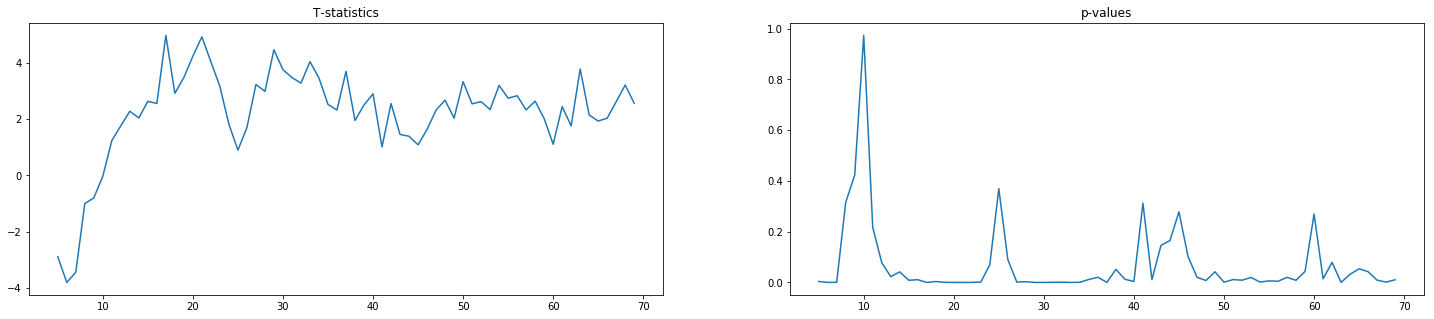

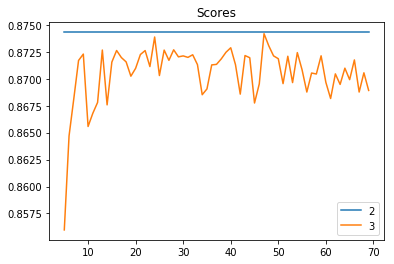

In [124]:
plt.figure(figsize = (25, 5))
plt.subplot(121)
check[0].plot(title = 'T-statistics')
plt.subplot(122)
check[1].plot(title = 'p-values')
check[[2, 3]].plot(title = 'Scores');

In [125]:
task1_not_outs_index = df_train_users.applymap(lambda x: x if abs(x) < 47 else np.nan).dropna().index

In [118]:
train_id, test_id = train_test_split(df_train_users.index, test_size = .2, 
                                     shuffle = True, random_state = 5)

prediction_with_outs = XGBRegressor() \
                        .fit(df_train_users.loc[train_id], task2_target.loc[train_id]['target']) \
                        .predict(df_train_users.loc[test_id])
        
base_score = np.sqrt(mean_squared_error(task2_target.loc[test_id]['target'], prediction_with_outs))
        
check = pd.DataFrame()
for i in range(5, 61):
    train_id_outs = np.intersect1d(train_id,
                          df_train_users.applymap(lambda x: x if abs(x) < i else np.nan).dropna().index)

    prediction_without_outs = XGBRegressor() \
                        .fit(df_train_users.loc[train_id_outs], task2_target.loc[train_id_outs]['target']) \
                        .predict(df_train_users.loc[test_id])
    tt = ttest_rel(prediction_with_outs, prediction_without_outs)
    check[i] = [tt[0], tt[1], base_score, \
                np.sqrt(mean_squared_error(task2_target.loc[test_id]['target'], prediction_without_outs))]
    
check = check.T
check.sort_values(by = 3).head(10)

,0,1,2,3
18,2.703135,0.006985,3.90272,3.892393
15,3.912087,0.000098,3.90272,3.893549
17,3.523276,0.000446,3.90272,3.898496
13,2.510504,0.012213,3.90272,3.904280
16,3.507956,0.000472,3.90272,3.904372
56,1.423614,0.154870,3.90272,3.904756
45,-0.932581,0.351262,3.90272,3.906197
44,-0.398216,0.690556,3.90272,3.906903
49,1.395500,0.163175,3.90272,3.907232
54,1.472975,0.141073,3.90272,3.908933


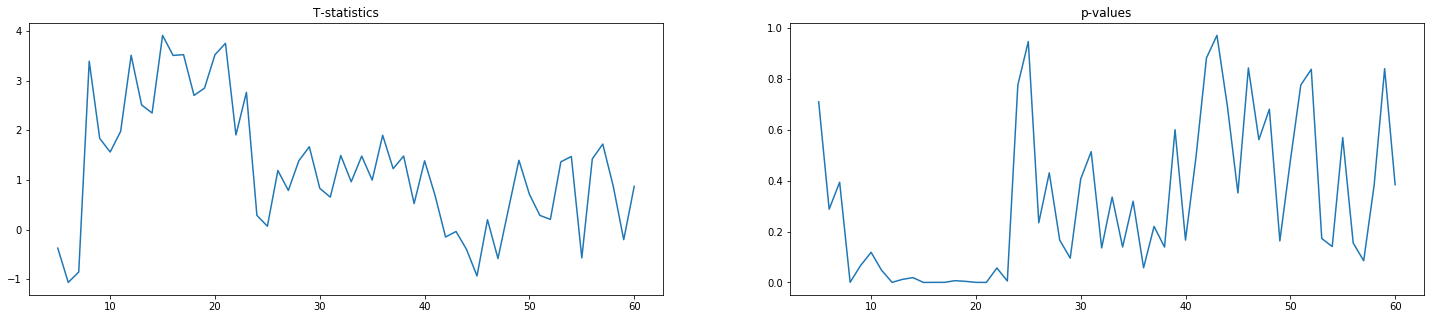

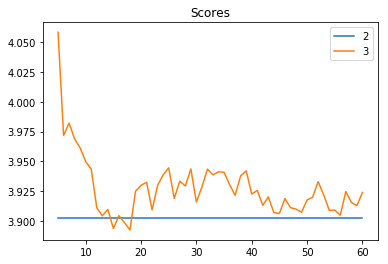

In [119]:
plt.figure(figsize = (25, 5))
plt.subplot(121)
check[0].plot(title = 'T-statistics')
plt.subplot(122)
check[1].plot(title = 'p-values')
check[[2, 3]].plot(title = 'Scores');

In [126]:
task2_not_outs_index = df_train_users.applymap(lambda x: x if abs(x) < 18 else np.nan).dropna().index

__TODO:__ to work with outliers by another way

# 3 step - training model

### 0 score: without tuning

In [168]:
res = CV_score_mean(1, df_train_users, task1_target['target'])
add_score(res, score_task1, 'without tuning')

score_task1

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,0.995243,0.000462019,0.835459,0.00769531,without tuning


In [169]:
res = CV_score_mean(2, df_train_users, task2_target['target'])
add_score(res, score_task2, 'without tuning')

score_task2

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,1.45214,0.0343277,4.24229,0.0561271,without tuning


### 1 score: without tuning, without outliers

In [170]:
res = CV_score_mean(1, df_train_users.loc[task1_not_outs_index], 
                       task1_target.loc[task1_not_outs_index]['target'])
add_score(res, score_task1, 'without tuning, without outliers')

score_task1

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,0.995243,0.000462019,0.835459,0.00769531,without tuning
1,0.995645,0.000388308,0.833051,0.00588503,"without tuning, without outliers"


In [171]:
res = CV_score_mean(2, df_train_users.loc[task2_not_outs_index], task2_target.loc[task2_not_outs_index]['target'])
add_score(res, score_task2, 'without tuning, without outliers')

score_task2

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,1.45214,0.0343277,4.24229,0.0561271,without tuning
1,1.20746,0.0388027,4.24897,0.0548743,"without tuning, without outliers"


### 2 score: learning_rate

__Task 1__

In [172]:
best_test_score = score_task1.iloc[0, 2]
learning_rate = .3

for p in [.001, .01, .1, .5, 1.]:
    res = CV_score_mean(1, df_train_users, task1_target['target'], 
                        params_est = {'learning_rate': p})
    
    test_score = res[2].mean(axis = 0)
    
    if test_score > best_test_score:
        learning_rate = p
        best_test_score = test_score

res = CV_score_mean(1, df_train_users, task1_target['target'], 
                    params_est = {'learning_rate': learning_rate})

add_score(res, score_task1, 'learning_rate = ' + str(learning_rate))
    
score_task1

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,0.995243,0.000462019,0.835459,0.00769531,without tuning
1,0.995645,0.000388308,0.833051,0.00588503,"without tuning, without outliers"
2,0.988046,0.000930504,0.851655,0.00767195,learning_rate = 0.1


In [174]:
task1_learning_rate = .1

__Task 2__

In [173]:
best_test_score = score_task2.iloc[0, 2]
learning_rate = .3

for p in [.001, .01, .1, .5, 1.]:
    res = CV_score_mean(2, df_train_users, task2_target['target'], 
                        params_est = {'learning_rate': p})
    
    test_score = res[2].mean(axis = 0)
    
    if test_score < best_test_score:
        learning_rate = p
        best_test_score = test_score

res = CV_score_mean(2, df_train_users, task2_target['target'], 
                    params_est = {'learning_rate': learning_rate})
                        
add_score(res, score_task2, 'learning_rate = ' + str(learning_rate))
    
score_task2

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,1.45214,0.0343277,4.24229,0.0561271,without tuning
1,1.20746,0.0388027,4.24897,0.0548743,"without tuning, without outliers"
2,2.38871,0.0345531,4.15758,0.051538,learning_rate = 0.1


In [175]:
task2_learning_rate = .1

### 3 score: max_depth

__Task 1__

In [176]:
best_test_score = score_task1.iloc[2, 2]
max_depth = 6

for p in [2, 3, 4, 5]:
    res = CV_score_mean(1, df_train_users, task1_target['target'], 
                        params_est = {'learning_rate': task1_learning_rate, 
                                      'max_depth': p})
    
    test_score = res[2].mean(axis = 0)
    
    if test_score > best_test_score:
        max_depth = p
        best_test_score = test_score

res = CV_score_mean(1, df_train_users, task1_target['target'], 
                    params_est = {'learning_rate': task1_learning_rate, 
                                  'max_depth': max_depth})

add_score(res, score_task1, 'max_depth = ' + str(max_depth))
    
score_task1

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,0.995243,0.000462019,0.835459,0.00769531,without tuning
1,0.995645,0.000388308,0.833051,0.00588503,"without tuning, without outliers"
2,0.988046,0.000930504,0.851655,0.00767195,learning_rate = 0.1
3,0.920756,0.00287052,0.856088,0.00788279,max_depth = 3


In [178]:
task1_max_depth = 3

__Task 2__

In [177]:
best_test_score = score_task2.iloc[2, 2]
max_depth = 6

for p in [2, 3, 4, 5]:
    res = CV_score_mean(2, df_train_users, task2_target['target'], 
                        params_est = {'learning_rate': task2_learning_rate, 
                                      'max_depth': p})
    
    test_score = res[2].mean(axis = 0)
    
    if test_score < best_test_score:
        max_depth = p
        best_test_score = test_score

res = CV_score_mean(2, df_train_users, task2_target['target'], 
                    params_est = {'learning_rate': task2_learning_rate, 
                                  'max_depth': max_depth})
                        
add_score(res, score_task2, 'max_depth = ' + str(max_depth))
    
score_task2

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,1.45214,0.0343277,4.24229,0.0561271,without tuning
1,1.20746,0.0388027,4.24897,0.0548743,"without tuning, without outliers"
2,2.38871,0.0345531,4.15758,0.051538,learning_rate = 0.1
3,3.25866,0.0289287,4.13917,0.0499984,max_depth = 4


In [179]:
task2_max_depth = 4

### 4 score: min_child_weight

__Task 1__

In [180]:
best_test_score = score_task1.iloc[3, 2]
min_child_weight = 1

for p in [3, 5, 7, 10]:
    res = CV_score_mean(1, df_train_users, task1_target['target'], 
                        params_est = {'learning_rate': task1_learning_rate, 
                                      'max_depth': task1_max_depth,
                                      'min_child_weight': p})
    
    test_score = res[2].mean(axis = 0)
    
    if test_score > best_test_score:
        min_child_weight = p
        best_test_score = test_score

res = CV_score_mean(1, df_train_users, task1_target['target'], 
                    params_est = {'learning_rate': task1_learning_rate, 
                                  'max_depth': task1_max_depth,
                                  'min_child_weight': min_child_weight})

add_score(res, score_task1, 'min_child_weight = ' + str(min_child_weight))
    
score_task1

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,0.995243,0.000462019,0.835459,0.00769531,without tuning
1,0.995645,0.000388308,0.833051,0.00588503,"without tuning, without outliers"
2,0.988046,0.000930504,0.851655,0.00767195,learning_rate = 0.1
3,0.920756,0.00287052,0.856088,0.00788279,max_depth = 3
4,0.920745,0.00293727,0.856439,0.00754001,min_child_weight = 7


In [213]:
task1_min_child_weight = 7

__Task 2__

In [181]:
best_test_score = score_task2.iloc[3, 2]
min_child_weight = 1

for p in [3, 5, 7, 10]:
    res = CV_score_mean(2, df_train_users, task2_target['target'], 
                        params_est = {'learning_rate': task2_learning_rate, 
                                      'max_depth': task2_max_depth,
                                      'min_child_weight': p})
    
    test_score = res[2].mean(axis = 0)
    
    if test_score < best_test_score:
        max_depth = p
        best_test_score = test_score

res = CV_score_mean(2, df_train_users, task2_target['target'], 
                    params_est = {'learning_rate': task2_learning_rate, 
                                  'max_depth': task2_max_depth,
                                  'min_child_weight': min_child_weight})
                        
add_score(res, score_task2, 'min_child_weight = ' + str(min_child_weight))
    
score_task2

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,1.45214,0.0343277,4.24229,0.0561271,without tuning
1,1.20746,0.0388027,4.24897,0.0548743,"without tuning, without outliers"
2,2.38871,0.0345531,4.15758,0.051538,learning_rate = 0.1
3,3.25866,0.0289287,4.13917,0.0499984,max_depth = 4
4,3.25866,0.0289287,4.13917,0.0499984,min_child_weight = 1


In [182]:
task2_min_child_weight = 1

### 5 score: gamma

__Task 1__

In [215]:
best_test_score = score_task1.iloc[4, 2]
gamma = 0

for p in [1, 3, 5]:
    res = CV_score_mean(1, df_train_users, task1_target['target'], 
                        params_est = {'learning_rate': task1_learning_rate, 
                                      'max_depth': task1_max_depth,
                                      'min_child_weight': task1_min_child_weight, 
                                      'gamma': p})
    test_score = res[2].mean(axis = 0)
    
    if test_score > best_test_score:
        gamma = p
        best_test_score = test_score

res = CV_score_mean(1, df_train_users, task1_target['target'], 
                    params_est = {'learning_rate': task1_learning_rate, 
                                  'max_depth': task1_max_depth,
                                  'min_child_weight': task1_min_child_weight,
                                  'gamma': gamma})

add_score(res, score_task1, 'gamma = ' + str(gamma))
    
score_task1

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,0.995243,0.000462019,0.835459,0.00769531,without tuning
1,0.995645,0.000388308,0.833051,0.00588503,"without tuning, without outliers"
2,0.988046,0.000930504,0.851655,0.00767195,learning_rate = 0.1
3,0.920756,0.00287052,0.856088,0.00788279,max_depth = 3
4,0.920745,0.00293727,0.856439,0.00754001,min_child_weight = 7
5,0.900002,0.00348565,0.856907,0.00801946,gamma = 1


In [216]:
task1_gamma = 1

__Task 2__

In [184]:
best_test_score = score_task2.iloc[4, 2]
gamma = 0

for p in [1, 3]:
    res = CV_score_mean(2, df_train_users, task2_target['target'], 
                        params_est = {'learning_rate': task2_learning_rate, 
                                      'max_depth': task2_max_depth,
                                      'min_child_weight': task2_min_child_weight, 
                                      'gamma': p})
    
    test_score = res[2].mean(axis = 0)
    
    if test_score < best_test_score:
        gamma = p
        best_test_score = test_score

res = CV_score_mean(2, df_train_users, task2_target['target'], 
                    params_est = {'learning_rate': task2_learning_rate, 
                                  'max_depth': task2_max_depth,
                                  'min_child_weight': task2_min_child_weight, 
                                  'gamma': gamma})

add_score(res, score_task2, 'gamma = ' + str(gamma))
    
score_task2

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,1.45214,0.0343277,4.24229,0.0561271,without tuning
1,1.20746,0.0388027,4.24897,0.0548743,"without tuning, without outliers"
2,2.38871,0.0345531,4.15758,0.051538,learning_rate = 0.1
3,3.25866,0.0289287,4.13917,0.0499984,max_depth = 4
4,3.25866,0.0289287,4.13917,0.0499984,min_child_weight = 1
5,3.25866,0.0289287,4.13917,0.0499984,gamma = 0


In [185]:
task2_gamma = 0

### 6 score: tuning parameters

__Task 1__

In [220]:
score_task1_tmp = pd.DataFrame(columns = score_columns)

In [222]:
print task1_learning_rate, task1_max_depth, task1_min_child_weight, task1_gamma

0.1 3 7 1


In [227]:
#best_test_score = score_task1.iloc[5, 2] # for the first running of the cell
best_test_score = score_task1_tmp.iloc[0, 2]

param = 1

for p in [.8, 1.2]:
    res = CV_score_mean(1, df_train_users, task1_target['target'], 
                        params_est = {'learning_rate': task1_learning_rate, 
                                      'max_depth': task1_max_depth,
                                      'min_child_weight': task1_min_child_weight, 
                                      'gamma': p})
    test_score = res[2].mean(axis = 0)
    
    if test_score > best_test_score:
        param = p
        best_test_score = test_score

res = CV_score_mean(1, df_train_users, task1_target['target'], 
                    params_est = {'learning_rate': task1_learning_rate, 
                                  'max_depth': task1_max_depth,
                                  'min_child_weight': task1_min_child_weight,
                                  'gamma': param})

add_score(res, score_task1_tmp, 'gamma = ' + str(param))
    
score_task1_tmp

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,0.900259,0.00385904,0.8572,0.00791385,min_child_weight = 10
1,0.920293,0.00317686,0.857734,0.00803269,max_depth = 4
2,0.900259,0.00385904,0.8572,0.00791385,learning_rate = 0.1
3,0.900259,0.00385904,0.8572,0.00791385,gamma = 1


In [228]:
task1_learning_rate = .1
task1_max_depth = 3
task1_min_child_weight = 10
task1_gamma = 1

In [233]:
params_1 = {'learning_rate': task1_learning_rate, 
            'max_depth': task1_max_depth,
            'min_child_weight': task1_min_child_weight,
            'gamma': task1_gamma}

__Task 2__

In [229]:
score_task2_tmp = pd.DataFrame(columns = score_columns)

In [230]:
print task2_learning_rate, task2_max_depth, task2_min_child_weight, task2_gamma

0.1 4 1 0


In [232]:
best_test_score = score_task2.iloc[5, 2]

param = 4

for p in [2, 3]:
    res = CV_score_mean(2, df_train_users, task2_target['target'], 
                        params_est = {'learning_rate': task2_learning_rate, 
                                      'max_depth': p,
                                      'min_child_weight': task2_min_child_weight, 
                                      'gamma': task2_gamma})
    test_score = res[2].mean(axis = 0)
    
    if test_score < best_test_score:
        param = p
        best_test_score = test_score

res = CV_score_mean(2, df_train_users, task2_target['target'], 
                    params_est = {'learning_rate': task2_learning_rate, 
                                  'max_depth': param,
                                  'min_child_weight': task2_min_child_weight,
                                  'gamma': task2_gamma})

add_score(res, score_task2_tmp, 'max_depth = ' + str(param))
    
score_task2_tmp

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,3.25866,0.0289287,4.13917,0.0499984,learning_rate = 0.1
1,3.25866,0.0289287,4.13917,0.0499984,max_depth = 4


In [234]:
task2_learning_rate = .1
task2_max_depth = 4
task2_min_child_weight = 1
task2_gamma = 0

In [235]:
params_2 = {'learning_rate': task2_learning_rate, 
            'max_depth': task2_max_depth,
            'min_child_weight': task2_min_child_weight,
            'gamma': task2_gamma}

### 5 score: reducing count of features

__Task 1__

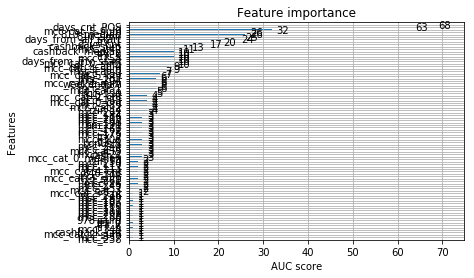

In [236]:
xgb = XGBClassifier(learning_rate = task1_learning_rate,
                    max_depth = task1_max_depth,
                    min_child_weight = task1_min_child_weight, 
                    gamma = task1_gamma) \
        .fit(df_train_users, task1_target['target'])
    
xgb_features_1 = xgb.booster().get_fscore()
plot_importance(xgb.booster(), xlabel='AUC score');

In [237]:
score_tmp = pd.DataFrame(columns = score_columns)
features_tmp_1 = pd.DataFrame(pd.Series(xgb_features_1))

for i in range(30):
    features_to_check = features_tmp_1[features_tmp_1[0] > i].index
    
    res = CV_score_mean(1, df_train_users[features_to_check], task1_target['target'], params_est = params_1)

    add_score(res, score_tmp, str(len(features_to_check)) + 'f (imp > ' + str(i) + ')')

score_tmp.sort_values(by = ['Test Score Mean'], ascending = False).head(10)

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
7,0.893979,0.00391175,0.859971,0.00795883,19f (imp > 7)
8,0.893979,0.00391175,0.859971,0.00795883,19f (imp > 8)
9,0.892385,0.00372045,0.859942,0.00820811,17f (imp > 9)
11,0.887385,0.00364427,0.859835,0.00798981,10f (imp > 11)
12,0.887385,0.00364427,0.859835,0.00798981,10f (imp > 12)
5,0.894815,0.00360982,0.859689,0.00787645,27f (imp > 5)
6,0.893009,0.00353263,0.85966,0.00795165,21f (imp > 6)
10,0.887392,0.00351279,0.85956,0.00796346,11f (imp > 10)
4,0.894389,0.00393984,0.859512,0.00812153,29f (imp > 4)
16,0.885934,0.00308593,0.859472,0.00796581,9f (imp > 16)


In [238]:
task1_features = features_tmp_1[features_tmp_1[0] > 9].index

res = CV_score_mean(1, df_train_users[task1_features], task1_target['target'], params_est = params_1)

add_score(res, score_task1, 'top 17 features')
    
score_task1

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,0.995243,0.000462019,0.835459,0.00769531,without tuning
1,0.995645,0.000388308,0.833051,0.00588503,"without tuning, without outliers"
2,0.988046,0.000930504,0.851655,0.00767195,learning_rate = 0.1
3,0.920756,0.00287052,0.856088,0.00788279,max_depth = 3
4,0.920745,0.00293727,0.856439,0.00754001,min_child_weight = 7
5,0.900002,0.00348565,0.856907,0.00801946,gamma = 1
6,0.892385,0.00372045,0.859942,0.00820811,top 17 features


__Task 2__

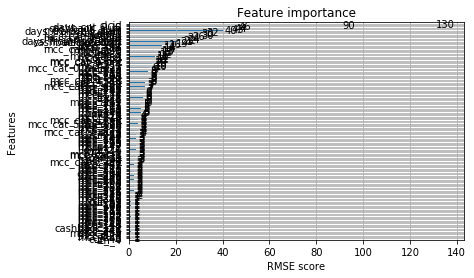

In [239]:
xgb = XGBRegressor(learning_rate = task2_learning_rate,
                    max_depth = task2_max_depth,
                    min_child_weight = task2_min_child_weight, 
                    gamma = task2_gamma) \
            .fit(df_train_users, task2_target['target'])
xgb_features_2 = xgb.booster().get_fscore()
plot_importance(xgb.booster(), xlabel='RMSE score');

In [243]:
score_tmp = pd.DataFrame(columns = score_columns)
features_tmp_2 = pd.DataFrame(pd.Series(xgb_features_2))

for i in range(40):
    features_to_check = features_tmp_2[features_tmp_2[0] > i].index
    
    res = CV_score_mean(2, df_train_users[features_to_check], task2_target['target'], params_est = params_2)

    add_score(res, score_tmp, str(len(features_to_check)) + 'f (imp > ' + str(i) + ')')

score_tmp.sort_values(by = ['Test Score Mean']).head(10)

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
11,3.26835,0.0334105,4.10472,0.0490809,23f (imp > 11)
7,3.22641,0.0318459,4.10513,0.0485359,43f (imp > 7)
8,3.22261,0.0306087,4.10649,0.049248,34f (imp > 8)
10,3.2493,0.0279288,4.1082,0.0501333,27f (imp > 10)
6,3.22578,0.0326565,4.10915,0.0466806,49f (imp > 6)
12,3.28605,0.0327274,4.10972,0.0474652,21f (imp > 12)
5,3.22701,0.0307865,4.10993,0.0470746,58f (imp > 5)
13,3.30125,0.0346709,4.10996,0.0494376,19f (imp > 13)
9,3.23515,0.030684,4.1123,0.0478834,32f (imp > 9)
15,3.31109,0.0346606,4.11339,0.0481737,16f (imp > 15)


In [242]:
task2_features = features_tmp_2[features_tmp_2[0] > 11].index

res = CV_score_mean(2, df_train_users[task2_features], task2_target['target'], params_est = params_2)

add_score(res, score_task2, 'top 23 features')
    
score_task2

,Train Score Mean,Train Score Std,Test Score Mean,Test Score Std,Comments
0,1.45214,0.0343277,4.24229,0.0561271,without tuning
1,1.20746,0.0388027,4.24897,0.0548743,"without tuning, without outliers"
2,2.38871,0.0345531,4.15758,0.051538,learning_rate = 0.1
3,3.25866,0.0289287,4.13917,0.0499984,max_depth = 4
4,3.25866,0.0289287,4.13917,0.0499984,min_child_weight = 1
5,3.25866,0.0289287,4.13917,0.0499984,gamma = 0
6,3.26835,0.0334105,4.10472,0.0490809,top 23 features


### 5 score: check all params for mean of some trees

__Task 1__

In [250]:
train_id, test_id = train_test_split(df_train_users.index.unique(), test_size = .3, 
                                     shuffle = True, random_state = 5)

task1_prediction = pd.DataFrame(index = df_train_users.loc[test_id].index)
task1_prediction[0] = XGBClassifier() \
                        .fit(df_train_users[task1_features].loc[train_id], task1_target.loc[train_id]['target']) \
                        .predict_proba(df_train_users[task1_features].loc[test_id])[:, 1]
task1_ttest = []
task1_p_value = []
        
for n in range(10, 301):
    temp = pd.DataFrame(index = df_train_users.loc[test_id].index)
    
    for rs in range(10):
        temp[0] = XGBClassifier(n_estimators = n,
                                learning_rate = task1_learning_rate,
                                max_depth = task1_max_depth,
                                min_child_weight = task1_min_child_weight, 
                                gamma = task1_gamma,
                                seed = rs)\
                        .fit(df_train_users[task1_features].loc[train_id], task1_target.loc[train_id]['target']) \
                        .predict_proba(df_train_users[task1_features].loc[test_id])[:, 1]
                
    task1_prediction[n] = temp.mean(axis = 1)
    
    tt = ttest_rel(task1_prediction[0], task1_prediction[n])
    task1_ttest.append(tt[0])
    task1_p_value.append(tt[1])

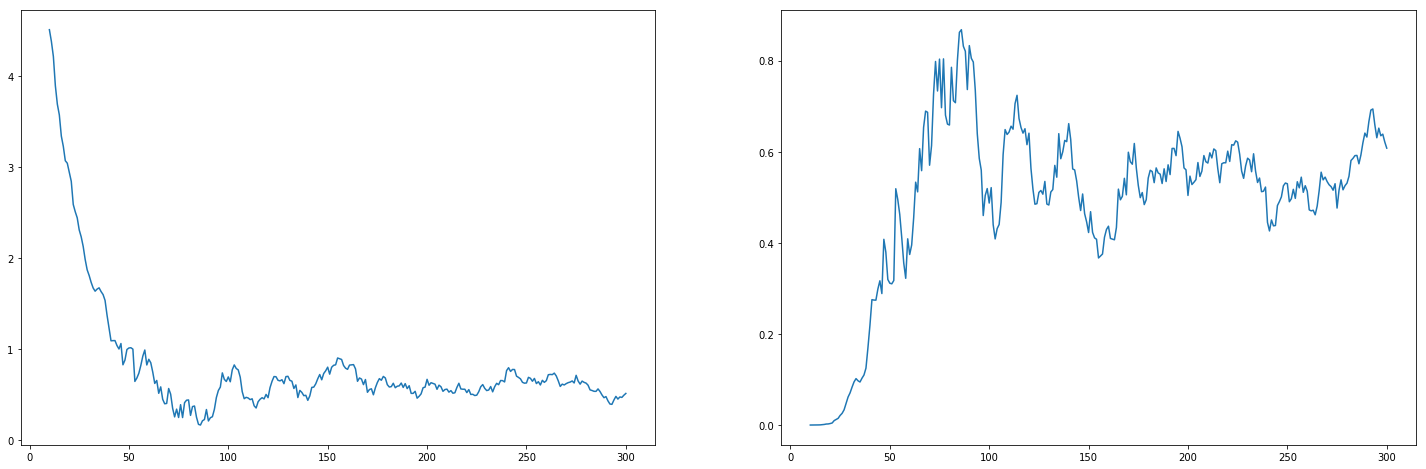

In [251]:
plt.figure(figsize = (25, 8))
plt.subplot(121)
plt.plot(range(10, 301), task1_ttest);
plt.subplot(122)
plt.plot(range(10, 301), task1_p_value);

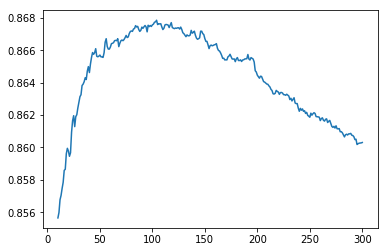

In [256]:
task1_score = task1_prediction.apply(lambda x: roc_auc_score(task1_target.loc[test_id]['target'], x), axis = 0)
plt.plot(range(10, 301), task1_score[1:]);

In [261]:
print np.mean(task1_score[100:110]), np.std(task1_score[100:110])

0.867501105088 0.000122379400143


    Test score mean     Test score std     Test LB
    0.864773380781      0.000289923739638  0.8460
    0.865725447807      0.000258135509042  0.8470
    0.866346399918      0.000127560628727  0.8478
    0.867501105088      0.000122379400143  0.8496 - current version

__Task 2__

In [262]:
train_id, test_id = train_test_split(df_train_users.index.unique(), test_size = .3, 
                                     shuffle = True, random_state = 5)

task2_prediction = pd.DataFrame(index = df_train_users.loc[test_id].index)
task2_prediction[0] = XGBRegressor() \
                        .fit(df_train_users[task2_features].loc[train_id], task2_target.loc[train_id]['target']) \
                        .predict(df_train_users[task2_features].loc[test_id])
task2_ttest = []
task2_p_value = []

for n in range(10, 301):
    temp = pd.DataFrame(index = df_train_users.loc[test_id].index)
    
    for rs in range(10):
        temp[0] = XGBRegressor(n_estimators = n,
                               learning_rate = task2_learning_rate,
                               max_depth = task2_max_depth,
                               min_child_weight = task2_min_child_weight, 
                               gamma = task2_gamma,
                               seed = rs)\
                        .fit(df_train_users[task2_features].loc[train_id], task2_target.loc[train_id]['target']) \
                        .predict(df_train_users[task2_features].loc[test_id])
                
    task2_prediction[n] = temp.mean(axis = 1)
    
    tt = ttest_rel(task2_prediction[0], task2_prediction[n])
    task2_ttest.append(tt[0])
    task2_p_value.append(tt[1])

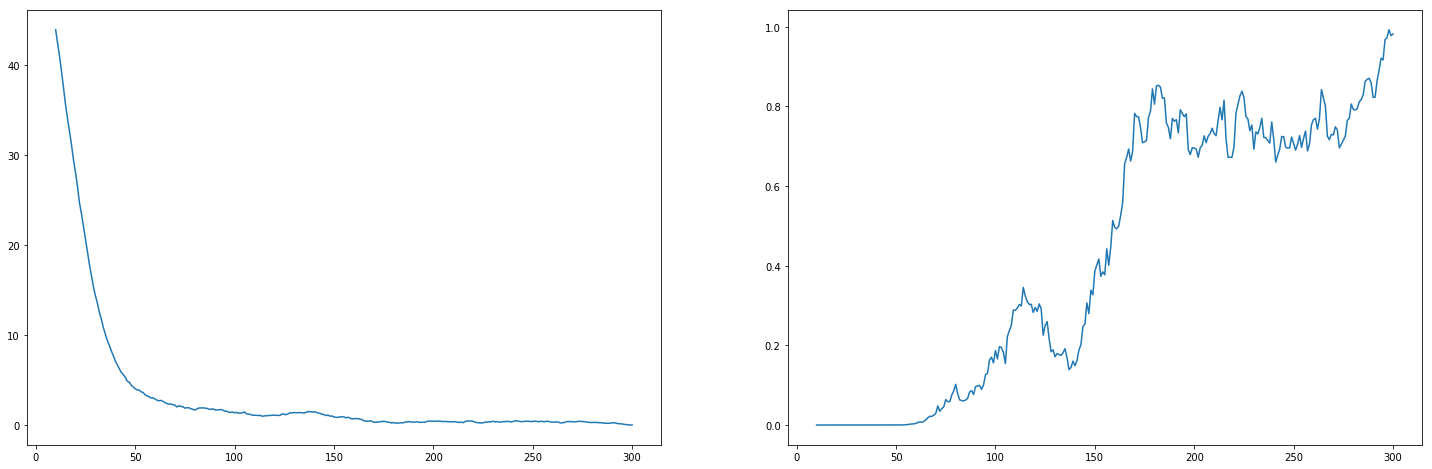

In [263]:
plt.figure(figsize = (25, 8))
plt.subplot(121)
plt.plot(range(10, 301), task2_ttest);
plt.subplot(122)
plt.plot(range(10, 301), task2_p_value);

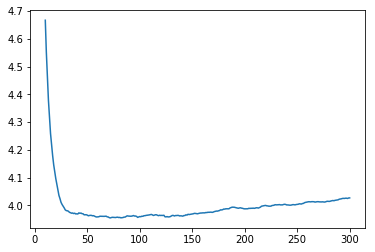

In [264]:
task2_score = task2_prediction \
                .apply(lambda x: np.sqrt(mean_squared_error(task2_target.loc[test_id]['target'], x)), axis = 0)
plt.plot(range(10, 301), task2_score[1:]);

In [279]:
print np.mean(task2_score[60:70]), np.std(task2_score[60:70])

3.95647288342 0.00106417617269


    Test score mean     Test score std     Test LB
    4.02379412198       0.00145149716086   4.7973
    3.95903623693       0.00161134342256   4.1505
    3.95647288342       0.00106417617269   4.1328 - current version

# 4 step - getting the final prediction

In [292]:
df_test = pd.read_csv('df_test.csv')
df_test.head()

,cl_id,MCC,channel_type,currency,amount,trx_category,trx_date,is_weekend,days_cnt,days_from_my_start,...,MCC_cat,is_cash,is_bonus,cashback,mcc_cat_4_sum,mcc_cat_0_sum,mcc_cat_5_sum,mcc_cat_1_sum,mcc_cat_3_sum,mcc_cat_2_sum
0,2,5814,0,810,-153.00,0,2017-04-18,0,90,74,...,4,1,0,10.7100,-153.00,-0.0,-0.0,-0.0,-0.0,-0.0
1,2,5812,0,810,-388.08,0,2017-03-10,0,90,35,...,4,1,0,27.1656,-388.08,-0.0,-0.0,-0.0,-0.0,-0.0
2,2,5691,0,810,-999.00,0,2017-02-21,0,90,18,...,0,1,0,69.9300,-0.00,-999.0,-0.0,-0.0,-0.0,-0.0
3,2,5814,0,810,-90.00,0,2017-04-26,0,90,82,...,4,1,0,6.3000,-90.00,-0.0,-0.0,-0.0,-0.0,-0.0
4,2,5814,0,810,-130.00,0,2017-04-08,1,90,64,...,4,1,0,9.1000,-130.00,-0.0,-0.0,-0.0,-0.0,-0.0


__Task 1__

In [284]:
task1_predictions_test = pd.DataFrame(index = df_test_users.index)

for n in range(100, 111):
    for rs in range(10):
        task1_predictions_test[n * 10 + rs] = XGBClassifier(n_estimators = n,
                                                            learning_rate = task1_learning_rate,
                                                            max_depth = task1_max_depth,
                                                            min_child_weight = task1_min_child_weight, 
                                                            gamma = task1_gamma,
                                                            seed = rs)\
                                                .fit(df_train_users[task1_features], task1_target['target']) \
                                                .predict_proba(df_test_users[task1_features])[:, 1]

task1_predictions_test['score'] = task1_predictions_test.mean(axis = 1)

In [294]:
task1_final = df_test[['cl_id']]
task1_final['_VAL_'] = task1_final['cl_id'] \
                                .apply(lambda x: task1_predictions_test.loc[x]['score'] 
                                                 if x in task1_predictions_test.index else 1)
task1_final['_VAL_'].fillna(1, inplace = True)
task1_final.columns = ['_ID_', '_VAL_']
task1_final.head()

,_ID_,_VAL_
0,2,0.824562
1,2,0.824562
2,2,0.824562
3,2,0.824562
4,2,0.824562


In [295]:
task1_final.to_csv('task1_prediction.csv', index = False)

__Task 2__

In [296]:
task2_predictions_test = pd.DataFrame(index = df_test_users.index)

for n in range(60, 71):
    for rs in range(10):
        task2_predictions_test[n * 10 + rs] = XGBRegressor(n_estimators = n,
                                                           learning_rate = task2_learning_rate,
                                                           max_depth = task2_max_depth,
                                                           min_child_weight = task2_min_child_weight, 
                                                           gamma = task2_gamma,
                                                           seed = rs)\
                                                .fit(df_train_users[task2_features], task2_target['target']) \
                                                .predict(df_test_users[task2_features])

task2_predictions_test['score'] = task2_predictions_test.mean(axis = 1)

In [299]:
task2_final = df_test[['cl_id']]
task2_final['_VAL_'] = task2_final['cl_id'] \
                                .apply(lambda x: task2_predictions_test.loc[x]['score'] 
                                                 if x in task2_predictions_test.index else 1)
task2_final['_VAL_'] = task2_final['_VAL_'].apply(lambda x: np.exp(x) - 1 if x > 1 else 1)
task2_final['_VAL_'].fillna(1, inplace = True)
task2_final.columns = ['_ID_', '_VAL_']
task2_final.head()

,_ID_,_VAL_
0,2,1196.445645
1,2,1196.445645
2,2,1196.445645
3,2,1196.445645
4,2,1196.445645


In [300]:
task2_final.to_csv('task2_prediction.csv', index = False)